In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi': 150})
# Use valid rcParams keys: set serif family and specify Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
import re
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('/Users/rommulus/Documents/Astronomy/arXiver/2025_Data.csv')
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,journals,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"ApJ (2025), 980 183",0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom..."
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,NaN,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France"
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,NaN,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,NaN,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit..."
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India"
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,NaN,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hungary, France, United..."


In [3]:
# Using affiliations column to get countries

# 1. Setup the replacement dictionary
replacement_dict = {
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'United States of America': 'United States',
    "People's Republic of China": 'China',
    'The Netherlands': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'The United Kingdom': 'United Kingdom'
}

# 2. Load the reference countries
# Assuming 'world_coords.csv' is in the current directory
try:
    world_coords = pd.read_csv('C:\\Users\\Rommulus\\Documents\\Astronomy\\arXiver\\world_coords.csv')
    # Create a set of valid countries for O(1) lookup speed
    valid_countries = set(world_coords['country'].unique())
except FileNotFoundError:
    print("Error: 'world_coords.csv' not found. Please ensure the file exists.")
    valid_countries = set()

# 3. Define the extraction function
def extract_countries_from_affiliations(affil_text):
    """
    Parses an affiliation string, splits by semicolon, and extracts 
    countries based on the valid_countries list and replacement_dict.
    """
    if not isinstance(affil_text, str) or not affil_text:
        return []

    found_countries = []
    
    # Split the row containing multiple affiliations by ';'
    affiliations = affil_text.split(';')
    
    for affil in affiliations:
        affil = affil.strip()
        if not affil:
            continue
            
        # Strategy: Look at the text after the last comma first (standard address format),
        # then fall back to checking the end of the string.
        
        # Get the last part after the last comma
        if ',' in affil:
            last_part = affil.split(',')[-1].strip()
        else:
            last_part = affil

        # Remove trailing periods (e.g., "USA." -> "USA")
        last_part_clean = last_part.rstrip('.')
        
        country_candidate = None

        # Check 1: Is this exact text in our replacement dict?
        if last_part_clean in replacement_dict:
            country_candidate = replacement_dict[last_part_clean]
        
        # Check 2: Is this exact text a valid country?
        elif last_part_clean in valid_countries:
            country_candidate = last_part_clean
            
        # Check 3 (Fallback): If the address is complex, iterate through keys/countries
        # to see if the string ENDS with them.
        else:
            # Check replacements via regex at end of string
            for key, val in replacement_dict.items():
                # Matches "Key" at end of string, optionally followed by a dot
                if re.search(r'\b' + re.escape(key) + r'\.?$', affil):
                    country_candidate = val
                    break
            
            # If still not found, check valid countries via regex at end of string
            if not country_candidate:
                for country in valid_countries:
                    if re.search(r'\b' + re.escape(country) + r'\.?$', affil):
                        country_candidate = country
                        break

        # If we identified a valid country (and it exists in our reference list)
        if country_candidate:
            # Ensure the replaced name is actually in our valid list 
            # (e.g. if 'United States' is in world_coords)
            if country_candidate in valid_countries:
                found_countries.append(country_candidate)
            else:
                # If the replacement map gives "United States" but world_coords 
                # strictly uses "USA" (unlikely based on your dict, but good safety),
                # we keep the candidate.
                found_countries.append(country_candidate)
                
    return found_countries

# 4. Apply the function to the dataframe
# Assuming your dataframe is named 'data'
if 'data' in locals():
    data['affil_countries'] = data['affiliations'].apply(extract_countries_from_affiliations)

    # Display the result to verify
    print(data[['affiliations', 'affil_countries']].head())
else:
    print("Dataframe 'data' not found. Please load your data first.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     affil_countries  
0      [United States, United States, United States]  
1                                                 []  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...  
3                                                 []  
4         [China, China, China, China, China, China]  


In [4]:
# For how many columns do we have counties in both affil_countries and latex_countries
count_both = 0
for affil_list, latex_list in zip(data['affil_countries'], data['latex_countries']):
    if affil_list and latex_list:
        count_both += 1
count_both

# Country name mismatches between affil_countries and latex_countries

def check_country_mismatches(df):
    """
    Identifies rows where the extracted 'affil_countries' list does not match 
    the parsed 'latex_countries' string.
    """
    
    # List to store indices of mismatching rows
    mismatch_indices = []

    # Iterate through the dataframe
    for index, row in df.iterrows():
        
        # 1. Get the generated list from the previous step
        derived_list = row['affil_countries']
        
        # 2. Get the manual/latex string
        latex_str = row['latex_countries']
        
        # 3. Filter: Only check rows that have valid entries in BOTH columns
        # Check if derived_list is valid (not None and not empty)
        has_derived = isinstance(derived_list, list) and len(derived_list) > 0
        
        # Check if latex_str is valid (not NaN/None and not empty string)
        has_latex = pd.notna(latex_str) and str(latex_str).strip() != ''
        
        if has_derived and has_latex:
            # 4. Convert latex string to list for comparison
            # Split by comma, strip whitespace around the country name
            latex_list = [c.strip() for c in str(latex_str).split(',') if c.strip()]
            
            # 5. Strict comparison (Order and Count must match exactly)
            if derived_list != latex_list:
                mismatch_indices.append(index)

    # 6. Create a dataframe subset containing only mismatches
    mismatched_rows = df.loc[mismatch_indices].copy()
    
    # Add a column showing the parsed latex list for easier visual comparison
    mismatched_rows['latex_list_parsed'] = mismatched_rows['latex_countries'].apply(
        lambda x: [c.strip() for c in str(x).split(',') if c.strip()]
    )
    
    return mismatched_rows

# --- Execution ---

# Run the check
mismatches = check_country_mismatches(data)

# Output results
if mismatches.empty:
    print("Success! No mismatches found between affiliations and latex_countries.")
else:
    print(f"Found {len(mismatches)} mismatches.")
    print("\nSample of mismatches (showing derived vs latex):")
    
    # specific columns to view
    cols_to_view = ['affil_countries', 'latex_list_parsed', 'affiliations']
    
    # Adjust pandas display options to ensure we see the full columns
    with pd.option_context('display.max_colwidth', None):
        print(mismatches[cols_to_view].head(10))

    # Optional: Save to CSV to inspect manually
    # mismatches.to_csv('country_mismatches.csv')


Found 7495 mismatches.

Sample of mismatches (showing derived vs latex):
                                                                                                                                                    affil_countries  \
4                                                                                                                        [China, China, China, China, China, China]   
5                                                                                     [China, China, China, China, China, China, China, China, China, China, China]   
6                                                                                                                                                   [United States]   
7                                                                                                                        [Spain, Spain, Spain, Spain, Spain, Spain]   
8   [Netherlands, United States, United States, United States, United States, United States,

In [5]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]"
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hung

In [6]:
# All countires column and first authors column

def process_country_columns(row):
    """
    Helper function to generate the 'all_countries' and 'first_author' data
    based on row values.
    """
    # --- Logic for 'all_countries' ---
    # Default to the extracted countries from affiliations
    final_all_countries = row['affil_countries']
    
    # Check if the list is empty or invalid (NaN/None)
    is_affil_empty = not isinstance(final_all_countries, list) or len(final_all_countries) == 0
    
    # If empty, fill from 'latex_countries'
    if is_affil_empty:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Convert comma-separated string to list
            final_all_countries = [x.strip() for x in str(latex_val).split(',') if x.strip()]
        else:
            final_all_countries = []

    # --- Logic for 'first_author' ---
    first_author_countries = []
    affil_text = row.get('affiliations')
    
    # 1. Try to get first author from 'affiliations' column
    # We split by ';' and take the first segment (index 0)
    if pd.notna(affil_text) and str(affil_text).strip() != '':
        first_segment = str(affil_text).split(';')[0]
        # Use the function defined in Step 1 to extract country from just this segment
        first_author_countries = extract_countries_from_affiliations(first_segment)
    
    # 2. If no country found in affiliations, fallback to first entry of 'latex_countries'
    if not first_author_countries:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Split by comma and take the first item
            first_latex_country = str(latex_val).split(',')[0].strip()
            if first_latex_country:
                first_author_countries = [first_latex_country]

    return pd.Series([final_all_countries, first_author_countries])

# Apply the logic to the dataframe
if 'data' in locals():
    data[['all_countries', 'first_author']] = data.apply(process_country_columns, axis=1)

    # Display results to verify
    cols_to_show = ['affiliations', 'latex_countries', 'all_countries', 'first_author']
    print(data[cols_to_show].head())
else:
    print("Dataframe 'data' not found.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     latex_countries  \
0                                                NaN   
1  United Kingdom, United Kingdom, United Kingdom...   
2                                                NaN   
3                                      Italy, France   
4                                            Germany   

                                       all_countries      first_author  
0      [United States, United States, United States]   [United States]  
1  [United Kingdom, United Kingdom, United Kingdo...  [United Kingdom]  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...           [Italy]  
3                                 

In [7]:
# Percentage of rows for which we have countries in 'all_countries' and 'first_author' columns

def calculate_fill_percentage(df, col_name):
    """
    Calculates the percentage of rows where col_name is a non-empty list.
    """
    total_rows = len(df)
    
    if total_rows == 0:
        return 0.0
    
    # Check if the value is a list AND has items in it
    # isinstance(x, list) filters out NaNs (floats) and None types safely
    non_empty_count = df[col_name].apply(
        lambda x: isinstance(x, list) and len(x) > 0
    ).sum()
    
    return (non_empty_count / total_rows) * 100

# --- Execution ---

if 'data' in locals():
    # Calculate percentages
    pct_all_countries = calculate_fill_percentage(data, 'all_countries')
    pct_first_author = calculate_fill_percentage(data, 'first_author')

    print(f"Total Rows: {len(data)}")
    print(f"Fill Rate for 'all_countries': {pct_all_countries:.2f}%")
    print(f"Fill Rate for 'first_author':  {pct_first_author:.2f}%")
else:
    print("Dataframe 'data' not found.")

Total Rows: 18660
Fill Rate for 'all_countries': 96.91%
Fill Rate for 'first_author':  96.77%


In [8]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States]
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy]
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0.0,0.0,0,1,"['

In [9]:
# Count number of rows with [] in 'all_countries' column
brackets_counter = 0
for countries in data['all_countries']:
    if countries == []:
        brackets_counter += 1
print(brackets_counter)

# Count number of rows with 'NaN' or missing values in 'all_countries' column
nan_counter = 0
for countries in data['all_countries']:
    if not isinstance(countries, list) or len(countries) == 0:
        nan_counter += 1
print(nan_counter)

576
576


In [10]:
world_coords

,country_code,latitude,longitude,country,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state
0,AD,42.546245,1.601554,Andorra,AK,63.588753,-154.493062,Alaska
1,AE,23.424076,53.847818,United Arab Emirates,AL,32.318231,-86.902298,Alabama
2,AF,33.939110,67.709953,Afghanistan,AR,35.201050,-91.831833,Arkansas
3,AG,17.060816,-61.796428,Antigua and Barbuda,AZ,34.048928,-111.093731,Arizona
4,AI,18.220554,-63.068615,Anguilla,CA,36.778261,-119.417932,California
...,...,...,...,...,...,...,...,...
240,YE,15.552727,48.516388,Yemen,NaN,NaN,NaN,NaN
241,YT,-12.827500,45.166244,Mayotte,NaN,NaN,NaN,NaN
242,ZA,-30.559482,22.937506,South Africa,NaN,NaN,NaN,NaN
243,ZM,-13.133897,27.849332,Zambia,NaN,NaN,NaN,NaN


In [11]:
# Number of Unique Countires in 'all_countries' column
unique_countries = set()
for countries in data['all_countries']:
    for country in countries:
        unique_countries.add(country)
print(len(unique_countries))

127


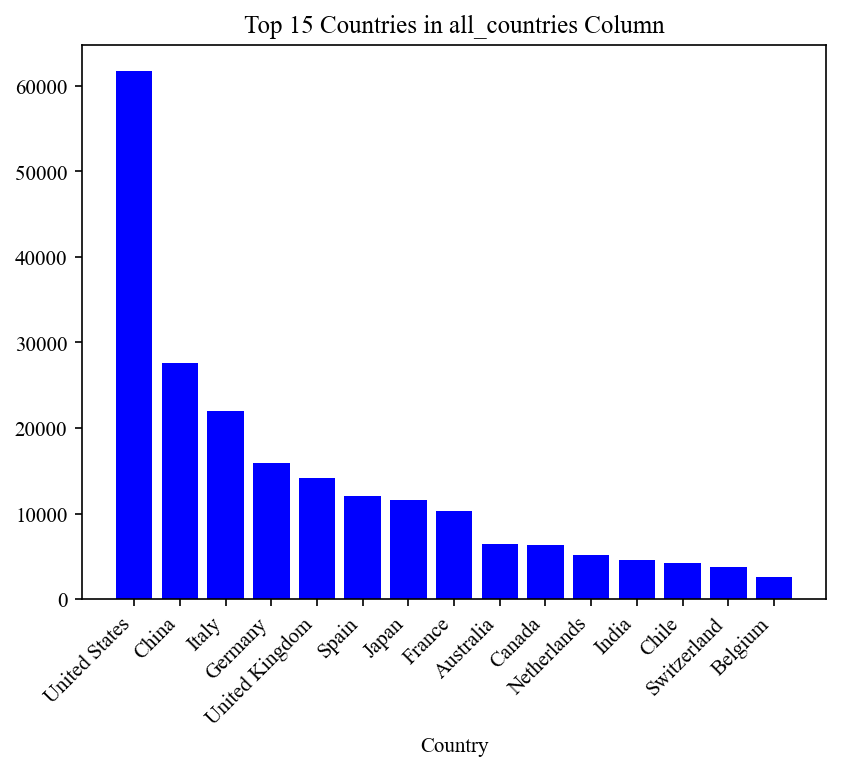

In [22]:
# Histogram of Top 15 Countries in 'all_countries' column
from collections import Counter
country_counter = Counter()
for countries in data['all_countries']:
    for country in countries:
        country_counter[country] += 1
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries in all_countries Column')
plt.xlabel('Country')
plt.show()

In [16]:
# Percentage that the 'US' and 'China' represent in 'all_countries' column
total_count = 0
us_count = 0
china_count = 0
for countries in data['all_countries']:
    for country in countries:
        total_count += 1
        if country == 'United States':
            us_count += 1
        elif country == 'China':
            china_count += 1
us_percentage = (us_count / total_count) * 100 if total_count > 0 else 0
china_percentage = (china_count / total_count) * 100 if total_count > 0 else 0
print(f"US Percentage: {us_percentage:.2f}%")
print(f"China Percentage: {china_percentage:.2f}%")

US Percentage: 25.61%
China Percentage: 11.43%


Text(0.5, 0, 'Country')

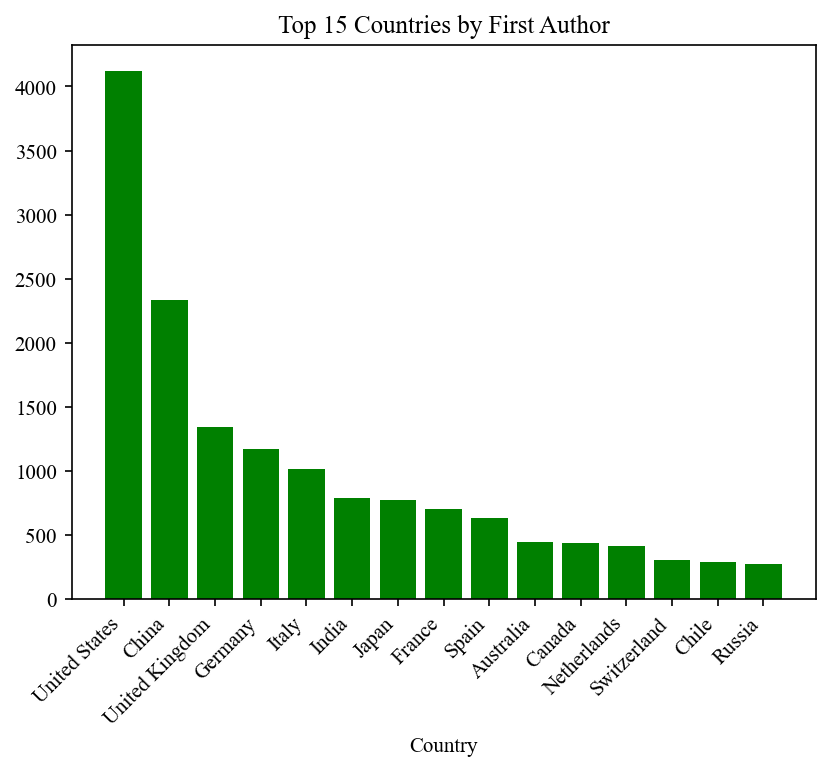

In [26]:
# Histogram ofr top 15 countriesin 'first_author' column
country_counts = []
for countries in data['first_author']:
    for country in countries:
        country_counts.append(country)
from collections import Counter
country_counter = Counter(country_counts)
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='green')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries by First Author')
plt.xlabel('Country')